**recsys-cluster-loss**

Example of cluster analysis in the context of recommendation systems.
Users who receive recommendations will be grouped based on the individual fairness measure of those recommendations.
The objective is to analyze whether there is any type of injustice of non-obvious user groups, that is, groups that cannot be configured based on some explicit user characteristic (variable) (for example: gender, age, etc.) .

Two methods of grouping will be applied:
1. Hierarchical clustering (tree clustering - dendrogram)
2. Non-hierarchical grouping by breakdown (grouping by k-Means)

In this file we are analyzing the possible groupings considering the following variable(s):
- gender: gender of users

Recommendation system: generating the recommendation matrix and calculating individual fairness

In [19]:
# cloning repository with database
!rm -rf recsys-cluster-loss
!git clone https://github.com/ravarmes/recsys-cluster-loss.git

Cloning into 'recsys-cluster-loss'...


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [2]:
import sys
sys.path.append('recsys-cluster-loss/src')
from RecSys import RecSys
from UserFairness import IndividualLossVariance
from UserFairness import GroupLossVariance

In [3]:
# reading data from 3883 movies and 6040 users 
Data_path = 'recsys-cluster-loss/data/MovieLens-1M'
n_users=  300
n_items= 1000
top_users = True # True: to use users with more ratings; False: otherwise
top_items = False # True: to use movies with more ratings; False: otherwise

In [4]:
# recommendation algorithm
algorithm = 'RecSysALS'

In [5]:
# parameters for calculating fairness measures
l = 5
theta = 3
k = 3

In [6]:
recsys = RecSys(n_users, n_items, top_users, top_items, l, theta, k)

In [7]:
X, users_info, items_info = recsys.read_movielens_1M(n_users, n_items, top_users, top_items, data_dir = Data_path) # returns matrix of ratings with n_users rows and n_moveis columns
omega = ~X.isnull() # matrix X with True in cells with evaluations and False in cells not rated

In [8]:
users_info

,Gender,Age,Occupation,Zip-code
1,2,1,10,48067
2,1,56,16,70072
3,1,25,15,55117
4,1,45,7,02460
5,1,25,20,55455
...,...,...,...,...
6036,2,25,15,32603
6037,2,45,1,76006
6038,2,56,1,14706
6039,2,45,0,01060


In [9]:
X_est = recsys.compute_X_est(X, algorithm, Data_path) # RecSysALS or RecSysKNN or RecSysNMF or RecSysExampleAntidoteData20Items

In [10]:
ilv = IndividualLossVariance(X, omega, 1)
losses = ilv.get_losses(X_est)

In [11]:
losses

UserID
4169    0.611130
1680    1.132248
4277    0.414079
1941    1.047745
1181    0.587892
          ...   
3320    1.072202
3462    0.875762
5011    0.664776
308     0.358923
1333    1.164655
Length: 300, dtype: float64

In [12]:
df = pd.DataFrame(columns=['Gender', 'Age', 'Occupation', 'Zip-code', 'Loss'])
df['Gender'] = users_info['Gender']
df['Age'] = users_info['Age']
df['Occupation'] = users_info['Occupation']
df['Zip-code'] = users_info['Zip-code']
df['NR'] = users_info['NR']
df['Loss'] = losses

df.dropna(subset=['Loss'], inplace=True) # eliminating rows with empty values in the 'Loss' column
df

,Gender,Age,Occupation,Zip-code,Loss
48,1,25,4,92107,0.370556
53,1,25,0,96931,0.516604
123,1,35,9,67208,0.487140
148,1,50,17,57747,1.033793
149,1,25,1,29205,0.607217
...,...,...,...,...,...
5916,1,50,20,48230,0.563316
5954,1,45,11,70802,1.492428
5996,2,25,0,87114,0.751011
6016,1,45,1,37209,0.591682


In [13]:
df.head()

,Gender,Age,Occupation,Zip-code,Loss
48,1,25,4,92107,0.370556
53,1,25,0,96931,0.516604
123,1,35,9,67208,0.487140
148,1,50,17,57747,1.033793
149,1,25,1,29205,0.607217


In [14]:
# number of rows and columns:
df.shape

(300, 5)

In [15]:
# descriptive statistics:
df.describe()

,Gender,Age,Occupation,Loss
count,300.000000,300.000000,300.000000,300.000000
mean,1.230000,28.776667,7.070000,0.788955
std,0.421536,10.259515,6.641194,0.307327
min,1.000000,1.000000,0.000000,0.293217
25%,1.000000,25.000000,1.000000,0.578627
50%,1.000000,25.000000,4.000000,0.727145
75%,1.000000,35.000000,14.000000,0.915155
max,2.000000,56.000000,20.000000,2.401739


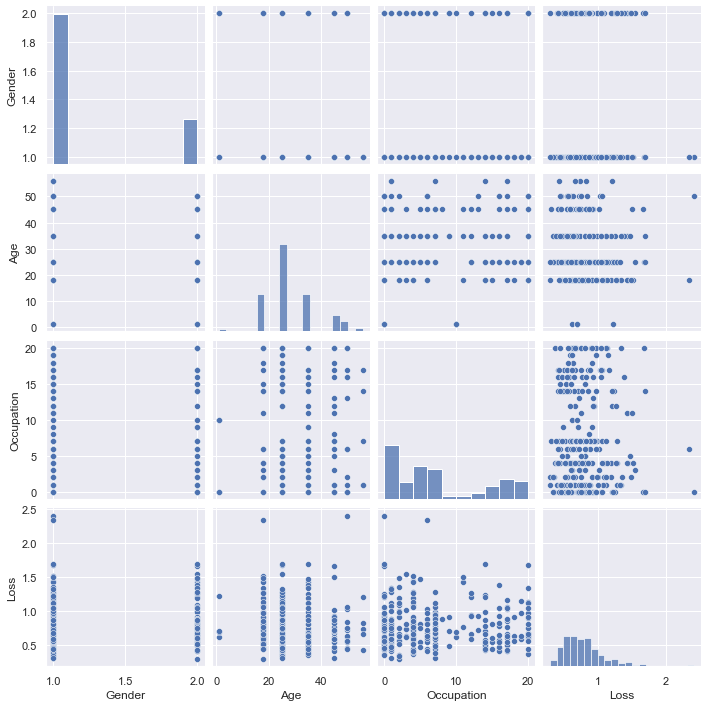

In [16]:
sns.pairplot(df)

<AxesSubplot:>

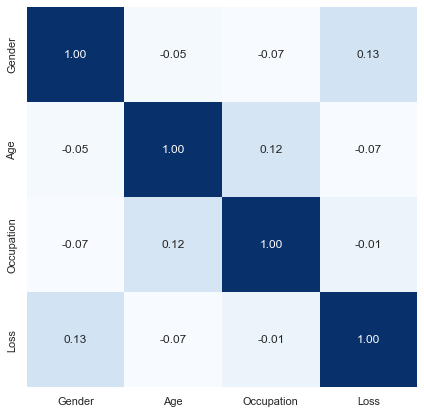

In [17]:
df = df.drop(['Zip-code'] , axis=1) # eliminating Zip-code (non-numeric) columns to analyze correlations

plt.figure(figsize=(7, 7))
corr = np.corrcoef(df.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=df.columns, yticklabels=df.columns)

Hierarchical clustering (tree clustering - dendrogram)

In [18]:
# Leaving only the Gender column to perform cluster analysis
df = df.drop('Loss', 1)
df = df.drop('Age', 1) 
df = df.drop('Occupation', 1) 
#df = df.drop('Gender', 1) 
df = df.drop('NR', 1) 

In [19]:
df_scaled = df.copy()
df_scaled.iloc[:, :] = StandardScaler().fit_transform(df)

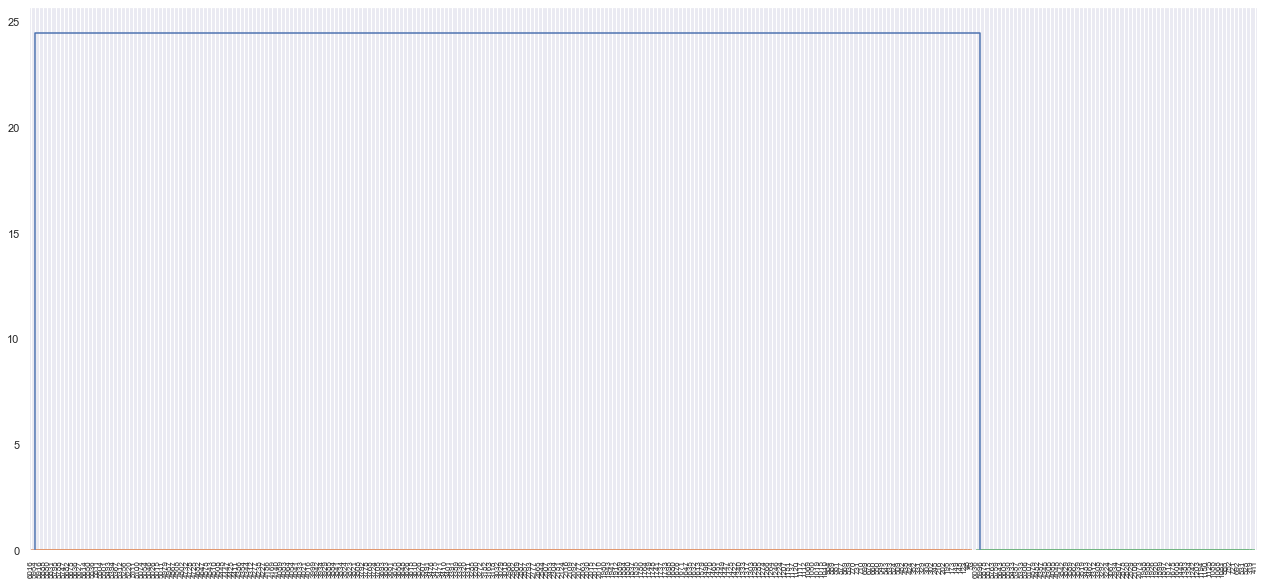

In [20]:
Z = hierarchy.linkage(df_scaled, 'ward') #complete or ward
plt.figure(figsize=(22, 10))
plt.grid(axis='y')
dn = hierarchy.dendrogram(Z, labels=list(df.index), leaf_font_size=8)

In [21]:
n_clusters = 2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
df_scaled['cluster_agglomerative'] = cluster.fit_predict(df_scaled)

In [22]:
# descriptive statistics of groups
df_groups = df.copy()
df_groups["cluster_agglomerative"] = cluster.labels_
df_groups = df_groups.groupby("cluster_agglomerative")
df_groups.describe()

Gender                                   
                       count mean  std  min  25%  50%  75%  max
cluster_agglomerative                                          
0                       69.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
1                      231.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0

In [23]:

users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}
for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [319, 411, 528, 531, 692, 721, 752, 855, 1051, 1068, 1088, 1125, 1150, 1194, 1203, 1242, 1354, 1383, 1448, 1605, 1675, 1812, 1897, 1899, 1920, 1926, 1958, 1988, 2073, 2106, 2529, 2820, 2878, 2907, 2934, 3067, 3224, 3292, 3308, 3312, 3462, 3483, 3519, 3539, 3562, 3589, 3829, 3842, 4048, 4085, 4305, 4345, 4387, 4482, 4579, 5107, 5306, 5333, 5387, 5433, 5530, 5605, 5643, 5759, 5763, 5812, 5878, 5996, 6036]

Cluster 1: [48, 53, 123, 148, 149, 173, 195, 202, 216, 245, 302, 308, 329, 331, 352, 424, 438, 482, 509, 524, 533, 543, 549, 550, 660, 678, 699, 710, 731, 770, 839, 869, 877, 881, 889, 984, 1010, 1015, 1019, 1050, 1069, 1112, 1117, 1120, 1137, 1181, 1207, 1224, 1246, 1264, 1266, 1274, 1285, 1298, 1303, 1317, 1333, 1340, 1422, 1425, 1447, 1449, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1647, 1671, 1676, 1680, 1698, 1733, 1737, 1741, 1748, 1749, 1764, 1780, 1835, 1837, 1880, 1884, 1889, 1912, 1941, 1943, 1980, 2010, 2012, 2015, 2030, 2063, 2077, 2092, 2109, 2116, 2124, 2

Non-hierarchical grouping (K-means)

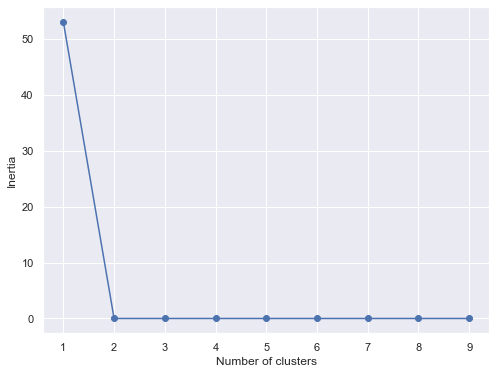

In [24]:
inertias = []
for k in np.arange(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)
    inertias.append(kmeans.inertia_)

# plotting the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 10), inertias, '-o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [25]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters)
df_scaled['cluster_kmeans'] = kmeans.fit_predict(df_scaled)

In [26]:
df_scaled

,Gender,cluster_agglomerative,cluster_kmeans
48,-0.546536,1,0
53,-0.546536,1,0
123,-0.546536,1,0
148,-0.546536,1,0
149,-0.546536,1,0
...,...,...,...
5916,-0.546536,1,0
5954,-0.546536,1,0
5996,1.829707,0,1
6016,-0.546536,1,0


In [27]:
users = list(df_scaled.index)
groups = df_scaled['cluster_agglomerative']

grouped_users = {i: [] for i in range(n_clusters)}

for user, group in zip(users, groups):
    grouped_users[group].append(user)

for gp, ctr in grouped_users.items():
    print(f'Cluster {gp}: {ctr}\n')

Cluster 0: [319, 411, 528, 531, 692, 721, 752, 855, 1051, 1068, 1088, 1125, 1150, 1194, 1203, 1242, 1354, 1383, 1448, 1605, 1675, 1812, 1897, 1899, 1920, 1926, 1958, 1988, 2073, 2106, 2529, 2820, 2878, 2907, 2934, 3067, 3224, 3292, 3308, 3312, 3462, 3483, 3519, 3539, 3562, 3589, 3829, 3842, 4048, 4085, 4305, 4345, 4387, 4482, 4579, 5107, 5306, 5333, 5387, 5433, 5530, 5605, 5643, 5759, 5763, 5812, 5878, 5996, 6036]

Cluster 1: [48, 53, 123, 148, 149, 173, 195, 202, 216, 245, 302, 308, 329, 331, 352, 424, 438, 482, 509, 524, 533, 543, 549, 550, 660, 678, 699, 710, 731, 770, 839, 869, 877, 881, 889, 984, 1010, 1015, 1019, 1050, 1069, 1112, 1117, 1120, 1137, 1181, 1207, 1224, 1246, 1264, 1266, 1274, 1285, 1298, 1303, 1317, 1333, 1340, 1422, 1425, 1447, 1449, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1647, 1671, 1676, 1680, 1698, 1733, 1737, 1741, 1748, 1749, 1764, 1780, 1835, 1837, 1880, 1884, 1889, 1912, 1941, 1943, 1980, 2010, 2012, 2015, 2030, 2063, 2077, 2092, 2109, 2116, 2124, 2

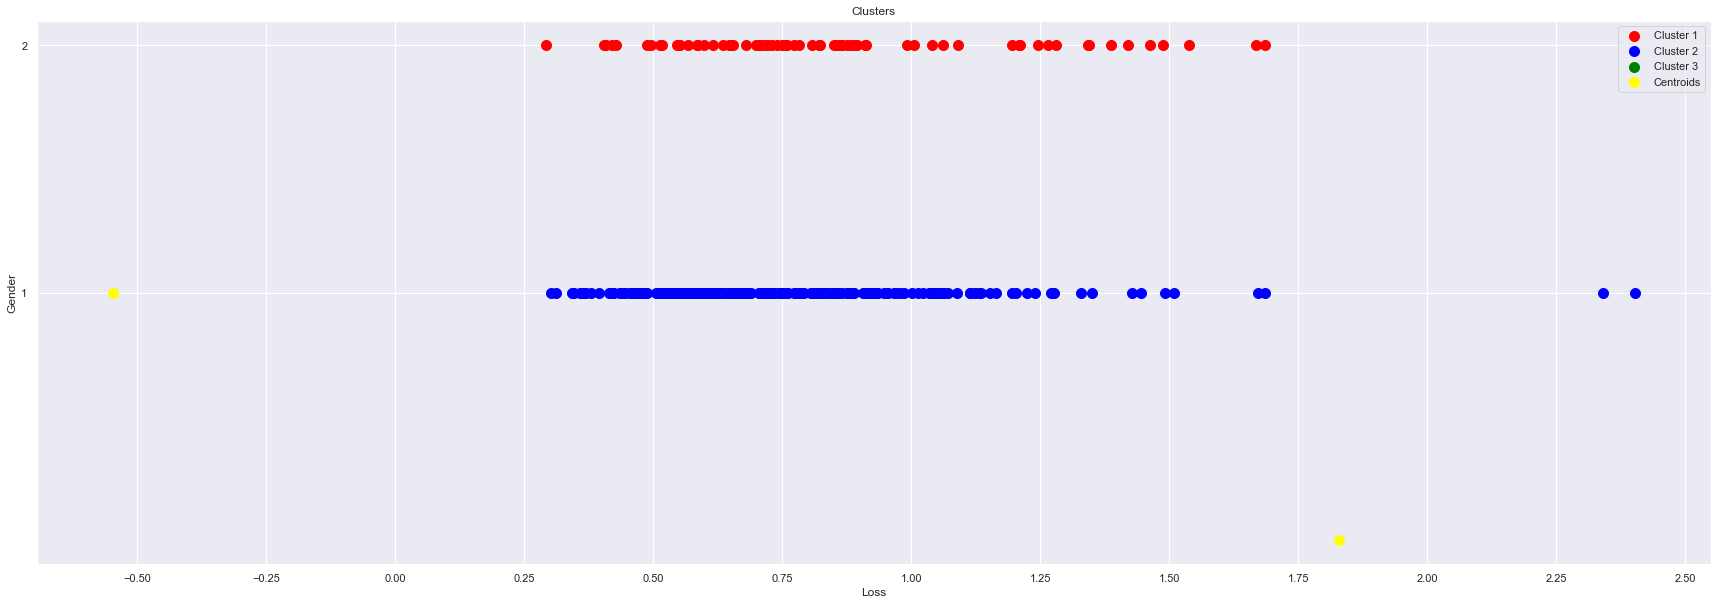

In [28]:
# visualising the clusters (Loss x Gender)
df['Loss'] = losses
X2 = df[['Loss' , 'Gender']].iloc[: , :].values

plt.figure( figsize=(30, 10)) # alterar tamanho
plt.xticks([-0.5,-0.25,0,0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]) # mudar escala do eixo X
plt.yticks([1, 2]) # mudar escala do eixo X

plt.scatter(X2[groups == 0, 0], X2[groups == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X2[groups == 1, 0], X2[groups == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X2[groups == 2, 0], X2[groups == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Loss')
plt.ylabel('Gender')
plt.legend()
plt.show()

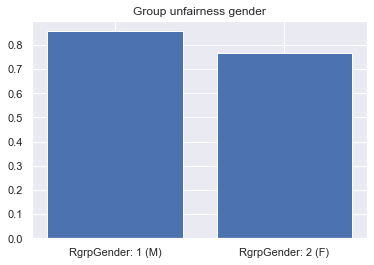

In [29]:
# G group: identifying the groups (Gender: gender of users)
# The configuration of groups was based in the hierarchical clustering (tree clustering - dendrogram)
# Clusters 1 and 2
G2 = {1: [319, 411, 528, 531, 692, 721, 752, 855, 1051, 1068, 1088, 1125, 1150, 1194, 1203, 1242, 1354, 1383, 1448, 1605, 1675, 1812, 1897, 1899, 1920, 1926, 1958, 1988, 2073, 2106, 2529, 2820, 2878, 2907, 2934, 3067, 3224, 3292, 3308, 3312, 3462, 3483, 3519, 3539, 3562, 3589, 3829, 3842, 4048, 4085, 4305, 4345, 4387, 4482, 4579, 5107, 5306, 5333, 5387, 5433, 5530, 5605, 5643, 5759, 5763, 5812, 5878, 5996, 6036], 2: [48, 53, 123, 148, 149, 173, 195, 202, 216, 245, 302, 308, 329, 331, 352, 424, 438, 482, 509, 524, 533, 543, 549, 550, 660, 678, 699, 710, 731, 770, 839, 869, 877, 881, 889, 984, 1010, 1015, 1019, 1050, 1069, 1112, 1117, 1120, 1137, 1181, 1207, 1224, 1246, 1264, 1266, 1274, 1285, 1298, 1303, 1317, 1333, 1340, 1422, 1425, 1447, 1449, 1451, 1465, 1470, 1496, 1579, 1613, 1632, 1635, 1647, 1671, 1676, 1680, 1698, 1733, 1737, 1741, 1748, 1749, 1764, 1780, 1835, 1837, 1880, 1884, 1889, 1912, 1941, 1943, 1980, 2010, 2012, 2015, 2030, 2063, 2077, 2092, 2109, 2116, 2124, 2181, 2304, 2453, 2507, 2544, 2665, 2777, 2793, 2857, 2887, 2909, 2962, 2986, 3018, 3029, 3032, 3118, 3163, 3182, 3272, 3280, 3285, 3311, 3320, 3336, 3389, 3391, 3401, 3410, 3471, 3475, 3476, 3491, 3507, 3526, 3610, 3618, 3626, 3648, 3650, 3675, 3681, 3683, 3693, 3705, 3724, 3768, 3778, 3792, 3808, 3821, 3823, 3824, 3834, 3841, 3884, 3885, 3929, 3934, 3942, 3999, 4016, 4021, 4033, 4041, 4054, 4064, 4083, 4089, 4140, 4169, 4186, 4227, 4238, 4277, 4312, 4344, 4354, 4386, 4411, 4425, 4447, 4448, 4508, 4510, 4543, 4578, 4647, 4682, 4725, 4728, 4732, 4802, 4808, 4867, 4957, 4979, 5011, 5015, 5026, 5046, 5054, 5074, 5100, 5111, 5220, 5256, 5312, 5367, 5394, 5493, 5501, 5504, 5511, 5536, 5550, 5614, 5627, 5636, 5675, 5682, 5747, 5788, 5795, 5831, 5880, 5888, 5916, 5954, 6016]}

glv = GroupLossVariance(X, omega, G2, 1) #axis = 1 (0 rows e 1 columns)
losses_RgrpGender = glv.get_losses(X_est)

RgrpGender_groups = ['RgrpGender: 1 (M)', 'RgrpGender: 2 (F)']
plt.bar(RgrpGender_groups, losses_RgrpGender)
plt.title('Group unfairness gender')
plt.show()